In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import numbers
from IPython.display import Image

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Model
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### In this tutorial: 

The major goal of is to show the steps to estimate the Foliar/Ground cover input parameters of the RHEM and its emulator from the remotes sensing data, latitute, longitude and soil texture of a location.

In an extra part, we calculated the runoff, soil loss and sediment yield of each location point using the estimated covers and the RHEM emulator. The full tutorial of using the RHEM emulator is in Use_Emulator.ipynb.

### 1- The Foliar and Ground covers estimator

We load the trained neural network that uses the time series of Landsat images and the climatic PRISM data to estimate the Foliar and Ground cover for each location. The shape of the Landsat time series is (20,3,3,22) which means 20 time steps (4 seasons of 5 years before the selected date. For instance, if we are going to estimate the Foliar and Ground covers of a location for Summer 2020, the seasonal time series starts from Fall 2015 and ends on Summer 2020), 3 by 3 pixels and, 22 channels including Landsat bands and some indices like NDVI, EVI, etc. The shape of the PRISM time series is (20, 2) which means 20 seasonal time steps and two climatic features of precipitation and temperature.

We used <a href="https://arxiv.org/abs/1804.07723">Partial Convolutional</a> layers in the neural network:

In [3]:
class PConv2D(tf.keras.layers.Conv2D):
    def __init__(self, mask_val=None, clip_threshold=None, output_mask_val=-999., prelu = False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask_val = mask_val
        self.clip_threshold = clip_threshold
        self.output_mask_val = output_mask_val
        self.prelu = prelu

    def build(self, input_shape):
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[channel_axis]
        
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.prelu = tf.keras.layers.PReLU()
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # threshold parameter for making the output mask
        
        if self.clip_threshold is None:
            self.thresh = self.add_weight(initializer= tf.random_normal_initializer(), trainable=True, name='img_thresh')

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, input0, mask0=None):
        images = input0
        
        if self.mask_val is None:
            if mask0 is None:
                raise Exception('Either of mask or mask_val must be specified')
                
            else:
                masks = mask0
        else:
            if mask0 is not None:
                raise Exception('mask and mask_val cannot be specified at the same time')
            
            else:
                masks = K.not_equal(images, self.mask_val)
                masks = K.cast(masks, dtype=K.floatx())

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )
        
        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = (self.window_size *  self.input_dim)/ (mask_output + 1e-8)

        if self.clip_threshold is not None: # 1- hard mask by a user defined threshold
            mask_output1 = tf.keras.activations.relu(tf.add(tf.subtract(mask_output, self.window_size *  self.input_dim * self.clip_threshold), 1), threshold=1)

        else: # 2- hard mask by a learnt threshold
            mask_output1 = tf.keras.activations.relu(tf.add(tf.subtract(mask_output, self.window_size *  self.input_dim * tf.keras.activations.sigmoid(self.thresh)), 1), threshold=1)
        
        mask_output1 = K.clip(mask_output1, 0, 1) 

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
            img_output = img_output * mask_output1 ### not adding bias to zeros
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
        
        else:
            if self.prelu:
                img_output = self.prelu(img_output)

        mask_999 = tf.math.subtract(1., mask_output1)
        mask_999 = tf.math.multiply(self.output_mask_val, mask_999)
        
        img_output = img_output * mask_output1
        img_output = img_output + mask_999
        
        return img_output

The Following cell contains modelCover() function. It creates the Foliar/Ground cover estimator with random weights and compile it. Then, the weights of the model are set to make the pre-trained model.

Note that the mask_val of the PConv2D layers are equal to -999. and the reason is the invalid pixels in the preprocessed Landsat data is equal to -999.

In [14]:
def modelCover():
    input1_band = tf.keras.layers.Input(shape=([20, 3, 3, 22]), name='Landsat_Input')

    x1_weight = tf.keras.layers.TimeDistributed(PConv2D(filters = 64, kernel_size=(1,1), data_format = 'channels_last', mask_val=-999., strides=1), 
                                name='Temporal_PartialConv1')(input1_band)
    
    x1 = tf.keras.layers.TimeDistributed(PConv2D(filters = 64, kernel_size=(1,1), data_format = 'channels_last', mask_val=-999., prelu=True, strides=1), 
                         name='Temporal_PartialConv2')(input1_band)

    max_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPool2D(), name='Global_maxPool')(x1)
    mask_lstm = tf.math.equal(max_pool, -999.)
    mask_lstm = K.cast(mask_lstm, dtype=K.floatx())
    mask_lstm = tf.math.reduce_sum(mask_lstm, axis=-1)
    mask_lstm = tf.math.equal(mask_lstm, 0.)

    mask_soft = tf.math.not_equal(x1_weight, -999.)
    mask_soft = K.cast(mask_soft, dtype=K.floatx())
    x1_weight = tf.keras.layers.Softmax(axis=[-2,-3])(x1_weight, mask=mask_soft)
    x1 = tf.keras.layers.Multiply()([x1,x1_weight])
    x1 = tf.math.divide_no_nan(tf.math.reduce_sum(x1, axis=[-2,-3]), tf.math.reduce_sum(mask_soft, axis=[-2,-3]))

    input1_prism = tf.keras.layers.Input(shape=([20, 2]), name = 'PRISM_Input')
    x1 = tf.keras.layers.Concatenate(axis=-1, name='Concatenate2')([x1, input1_prism])

    x1 = tf.keras.layers.SimpleRNN(128, name='RNN')(x1, mask=mask_lstm)

    input1_coords = tf.keras.layers.Input(shape=([11,]), name='coordinates_Input')
    x1 = tf.keras.layers.Concatenate(axis=-1, name='Concatenate3')([x1, input1_coords])


    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.Dropout(0.1)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.Dropout(0.1)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.Dropout(0.1)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    x1 = tf.keras.layers.Dense(128)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    
        
    output2_ground = tf.keras.layers.Dense(5, activation='softmax', name='ground_softmax')(x1)

    litter = tf.keras.layers.Lambda(lambda x: x[...,0:1], name='Litter')(output2_ground)
    biocrust = tf.keras.layers.Lambda(lambda x: x[...,1:2], name='BiologicalCrusts')(output2_ground)
    basal = tf.keras.layers.Lambda(lambda x: x[...,2:3], name='Basal')(output2_ground)
    rock = tf.keras.layers.Lambda(lambda x: x[...,3:4], name='Rock')(output2_ground)
    diffGround = tf.keras.layers.Lambda(lambda x: x[...,4:5], name='diffGround')(output2_ground)
    
    output2_foliar = tf.keras.layers.Dense(5, activation='softmax', name='foliar_softmax')(x1)
    
    forbs = tf.keras.layers.Lambda(lambda x: x[...,0:1], name='Forbs')(output2_foliar)
    bunch = tf.keras.layers.Lambda(lambda x: x[...,1:2], name='BunchGrass')(output2_foliar)
    shrub = tf.keras.layers.Lambda(lambda x: x[...,2:3], name='Shrubs')(output2_foliar)
    sod = tf.keras.layers.Lambda(lambda x: x[...,3:4], name='SodGrass')(output2_foliar)
    diffFoliar = tf.keras.layers.Lambda(lambda x: x[...,4:5], name='diffFoliar')(output2_foliar)


    modelRS = Model(inputs = [input1_band, input1_prism, input1_coords], 
                    
                    outputs = [litter, biocrust, basal, rock, diffGround, 
                               forbs, bunch, shrub, sod, diffFoliar], 
                    
                    name='RS_feed_to_Emulator')
    
    modelRS.compile(loss={'Litter': 'mse', 'BiologicalCrusts': 'mse', 'Basal': 'mse', 'Rock': 'mse', 'diffGround': 'mse',
                          'Forbs': 'mse', 'BunchGrass': 'mse', 'Shrubs': 'mse', 'SodGrass': 'mse', 'diffFoliar': 'mse'
                         }, 
                    
                    optimizer='adam',
                    
                    metrics={'Litter': 'mae', 'BiologicalCrusts': 'mae', 'Basal': 'mae', 'Rock': 'mae', 'diffGround': 'mae',
                              'Forbs': 'mae', 'BunchGrass': 'mae', 'Shrubs': 'mae', 'SodGrass': 'mae', 'diffFoliar': 'mae'
                         }
                   )
    
    return modelRS

modelRS = modelCover()
modelRS.load_weights('Files/RS_Model_weights/saved_weights')

#### We load the grid dataset. Each row is one of the pixels of the grid. Here, the grid dataset is located within Nebraska, Keith County (the Pink spot in the map). Load the following cell to see the map location

** Please note that we load 10 grid pixels in this notebook just as an example of how the model works

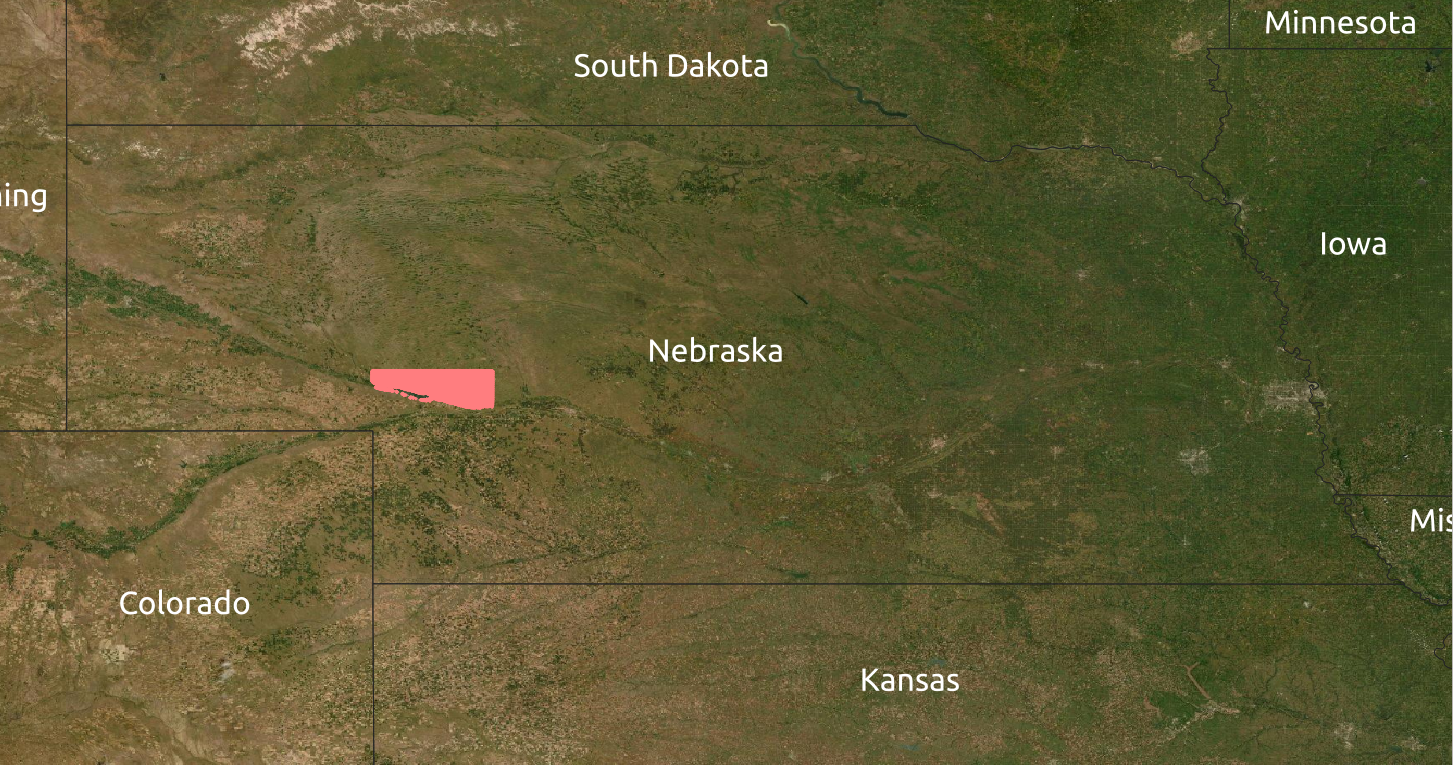

In [5]:
Image(filename='Files/Map.png', width=500, height=300)

In [15]:
dataset = pd.read_csv('Files/Data/RS_dataset_example.csv')
dataset['index1'] = dataset.index
dataset

,PrimaryKey,station_ID,slope,slope_shape,soilTexture,G,DIST,POR,SMAX,FRAC1,FRAC2,FRAC3,FRAC4,FRAC5,Latitude_NAD83,Longitude_NAD83,index1
0,1,ne256385,1.205216,concave,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394885,-102.054801,0
1,2,ne256385,1.205216,convex,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394937,-102.053718,1
2,3,ne256385,2.286737,convex,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394988,-102.052636,2
3,4,ne256385,3.408867,convex,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.395039,-102.051554,3
4,5,ne256385,2.748316,concave,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.395090,-102.050471,4
5,6,ne256385,0.538989,concave,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.395141,-102.049389,5
6,7,ne256385,0.000000,uniform,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394083,-102.054732,6
7,8,ne256385,1.077978,uniform,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394134,-102.053649,7
8,9,ne256385,2.286737,convex,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394185,-102.052567,8
9,10,ne256385,4.104819,convex,loam,110,0.25,0.4531,0.94,0.0498,0.1128,0.2877,0.4004,0.1494,41.394236,-102.051485,9


#### We prepare and normalize the model inputs in the following cells

#### 1- Extract the required columns of the grid dataset and normalize the 'G', 'Longitude' and 'Latitude' columns.

In [16]:
X = dataset.loc[:,['PrimaryKey', 'Latitude_NAD83', 'Longitude_NAD83', 'G', 'DIST', 'POR', 'SMAX', 
                     'FRAC1', 'FRAC2', 'FRAC3', 'FRAC4', 'FRAC5']].values

with open("Files/Normalizers/normalizer_G.pkl", "rb") as input_file:
    minmaxt_x = pickle.load(input_file)
X[:,[3]] = minmaxt_x.transform(X[:,[3]])

X[:,2:3] = (X[:,2:3]+124.848)/(-66.885 + 124.848) #long
X[:,1:2] = (X[:,1:2]- 24.396)/(49.384 - 24.396) #lat

x_pred = X.copy()

print('x_pred:', x_pred.shape, '10 grid pixels, 1 PrimaryKey attribute so we can load the corresponding Landsat and PRISM npz files + 11 attributes of soil and lat/long info')

x_pred: (10, 12) 10 grid pixels, 1 PrimaryKey attribute so we can load the corresponding Landsat and PRISM npz files + 11 attributes of soil and lat/long info


#### 3- Create a data generator which prepares the model input by matching the grid dataset table with the loaded arrays:

Here we read each row of the dataset table (which is now in the form of x_pred array) and read the lat/long and soil attributes of the row and load its Landsat and PRISM npz files. Then we create batches of the rows in the format that the model input layer expects.

The batch size must be compatible with the memory. Very high batch size may result in the crash. Very low batch size on the other hand, may result in a long waiting for the code run. 

In this example we have just 10 rows so we can use any number. So, specify the variable "batch_size" with any positive integer number less than 11.

In [17]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, image_filenames, coords, batch_size) :
        self.image_filenames = image_filenames
        self.coords = coords
        self.batch_size = batch_size
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int64)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size].astype(int)
        batch_x2 = self.coords[idx * self.batch_size : (idx+1) * self.batch_size]
        
        j = 0
        for i in batch_x:
            landsat_temp = np.load('Files/Data/RS_preprocessed_data/Landsat/{}.npz'.format(i),allow_pickle=True, mmap_mode='r')['arr_0'].astype('float32')
            landsat_temp = np.expand_dims(landsat_temp, axis=0)
            prism_temp = np.load('Files/Data/RS_preprocessed_data/PRISM/{}.npz'.format(i),allow_pickle=True, mmap_mode='r')['arr_0'].astype('float32')
            prism_temp = np.expand_dims(prism_temp, axis=0)
            
            if j == 0:
                landsat = landsat_temp.copy()
                prism = prism_temp.copy()
            else:
                landsat = np.concatenate([landsat, landsat_temp], axis=0)
                prism = np.concatenate([prism, prism_temp], axis=0)
            
            j += 1
        
        return {'Landsat_Input':landsat, 'PRISM_Input':prism, 'coordinates_Input':batch_x2.astype(np.float32)}

##### select the batch size here #####
batch_size = 5    
data_generator = My_Custom_Generator(x_pred[:,0], x_pred[:,1:], batch_size)

def gen_data_generator():
    for i in range(data_generator.__len__()):
        yield data_generator.__getitem__(i)

dataset_batched =  tf.data.Dataset.from_generator(gen_data_generator, output_types=({'Landsat_Input':tf.float32, 'PRISM_Input':tf.float32, 
                                                                                  'coordinates_Input':np.float32}))

dataset_batched = dataset_batched.apply(tf.data.experimental.copy_to_device("/gpu:0"))
dataset_batched = dataset_batched.prefetch(tf.data.AUTOTUNE)

for elem in dataset_batched.take(1):
    print('The shape of the Landsat data in the first batch is:',elem['Landsat_Input'].shape)

The shape of the Landsat data in the first batch is: (5, 20, 3, 3, 23)


#### Here we estimate the Foliar/Ground cover for each grid pixel
##### 8 columns with the model estimation of the Foliar/Ground categories will be added to the dataset table

In [18]:
predict = modelRS.predict(dataset_batched)

dataset.loc[:, 'Litter'] = predict[0]*100.
dataset.loc[:, 'BiologicalCrusts'] = predict[1]*100.
dataset.loc[:, 'Basal'] = predict[2]*100.
dataset.loc[:, 'Rock'] = predict[3]*100.

dataset.loc[:, 'Forbs'] = predict[5]*100.
dataset.loc[:, 'BunchGrass'] = predict[6]*100.
dataset.loc[:, 'Shrubs'] = predict[7]*100.
dataset.loc[:, 'SodGrass'] = predict[8]*100.
dataset

,PrimaryKey,station_ID,slope,slope_shape,soilTexture,G,DIST,POR,SMAX,FRAC1,...,Longitude_NAD83,index1,Litter,BiologicalCrusts,Basal,Rock,Forbs,BunchGrass,Shrubs,SodGrass
0,1,ne256385,1.205216,concave,loam,110,0.25,0.4531,0.94,0.0498,...,-102.054801,0,69.207085,0.145848,14.296646,0.488902,10.034795,64.350082,2.573475,12.960793
1,2,ne256385,1.205216,convex,loam,110,0.25,0.4531,0.94,0.0498,...,-102.053718,1,58.733212,0.139605,16.930849,0.963981,7.692143,66.543465,2.483730,8.829957
2,3,ne256385,2.286737,convex,loam,110,0.25,0.4531,0.94,0.0498,...,-102.052636,2,53.193886,0.144352,13.789588,1.180609,6.991716,62.921749,3.230303,7.223722
3,4,ne256385,3.408867,convex,loam,110,0.25,0.4531,0.94,0.0498,...,-102.051554,3,56.535538,0.251141,12.074080,1.217327,7.045266,58.865772,4.201770,9.294903
4,5,ne256385,2.748316,concave,loam,110,0.25,0.4531,0.94,0.0498,...,-102.050471,4,59.686005,0.216526,11.416050,1.097123,7.643026,59.078400,4.045311,9.245586
5,6,ne256385,0.538989,concave,loam,110,0.25,0.4531,0.94,0.0498,...,-102.049389,5,61.429482,0.180963,11.969893,0.800596,8.293050,61.696781,2.966405,8.918554
6,7,ne256385,0.000000,uniform,loam,110,0.25,0.4531,0.94,0.0498,...,-102.054732,6,64.000748,0.202175,14.507562,0.790364,8.688352,63.969463,3.061074,11.385168
7,8,ne256385,1.077978,uniform,loam,110,0.25,0.4531,0.94,0.0498,...,-102.053649,7,63.169472,0.173860,14.885181,0.777035,8.134020,65.301582,2.901100,10.575258
8,9,ne256385,2.286737,convex,loam,110,0.25,0.4531,0.94,0.0498,...,-102.052567,8,61.581238,0.165381,16.046850,0.949402,7.849978,65.190971,2.870971,10.057782
9,10,ne256385,4.104819,convex,loam,110,0.25,0.4531,0.94,0.0498,...,-102.051485,9,56.191845,0.184532,15.215595,1.259482,6.758658,64.011803,3.278792,9.119331


#### 2- Now it is time to get the runoff, soil loss and the sediment yield using the RHEM emulator.

#### 1- We first load the pretrained emulator:

In [29]:
def weighted_binary_crossentropy(zero_weight=1.0, one_weight=1.0):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype='float64')
        y_pred = tf.cast(y_pred, dtype='float64')
        b_ce = K.binary_crossentropy(y_true, y_pred)
        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
emulator = tf.keras.models.load_model('Files/Trained_Emulator/emulator.h5', 
                                      custom_objects={ 'weighted_binary_crossentropy': weighted_binary_crossentropy()})

#### 2- Then we load the normalizer files and prepare the RHEM scenarios out of the grid dataset


In [31]:
with open('Files/Normalizers/minmaxt_x.pkl', 'rb') as file:
    minmaxt_x = pickle.load(file)    
with open('Files/Normalizers/minmaxt_y_runoff.pkl', 'rb') as file:
    minmaxt_y_runoff = pickle.load(file)
with open('Files/Normalizers/minmaxt_y_erosion.pkl', 'rb') as file:
    minmaxt_y_erosion = pickle.load(file)

The get_cligen_pars(), slope_prop(), soil_prop_from_texture(), check_the_ground_covers(), the check_the_foliar_covers() and, create_input() functions are required to prepare the RHEM scenario in batch mode as mentioned in the Use_Emulator.ipynb tutorial notebook.

In [33]:
cligenTab = pd.read_csv('Files/Parameter_Files/cligen.csv')
def get_cligen_pars(station_ID):
    
    if type(station_ID) != str:
        raise Exception('The stationID must be a string')

    if station_ID not in cligenTab['ID'].values.tolist():
        raise Exception('stationID is not among the available CLIGEN stations')

    cligenPar = cligenTab[cligenTab['ID'] == station_ID].iloc[0,:-1].values
    return cligenPar[0], cligenPar[1], cligenPar[2], cligenPar[3]


def slope_prop(slope, slope_shape):
    
    if not isinstance(slope, numbers.Number):
        raise Exception('The slope must be a number between 0 and 100 inclusive')
    if slope > 100 or slope < 0:
        raise Exception('The slope must be between 0 and 100 inclusive')
        
    if type(slope_shape) != str:
        raise Exception('The slope shape must be one of the following: uniform, convex, concave')
    
    slope_shape = slope_shape.lower()
    if slope_shape not in ['uniform', 'convex', 'concave']:
        raise Exception('The slope shape must be one of the following: uniform, convex, concave')
        
    if slope_shape == 'uniform':
        SL1 = slope/100
        SL2 = slope/100

    elif slope_shape == 'convex':
        SL1 = 0.001
        SL2 = slope/100

    else:
        SL1 = slope/100
        SL2 = 0.001
    
    return SL1, SL2


soil = pd.read_csv('Files/Parameter_Files/Soil_Hydraulic_Properties.csv')
def soil_prop_from_texture(soilTexture):
    soilTexture = soilTexture.lower()
    if not soilTexture in soil.Soil_Texture_Class.values.tolist():
        raise Exception('The Selected soil texture is unknown')
    else:
        soilParameters = soil[soil['Soil_Texture_Class'] == soilTexture].values[0,1:].tolist()
        return soilParameters[0], soilParameters[1], soilParameters[2], soilParameters[3], soilParameters[4], soilParameters[5], soilParameters[6], soilParameters[7], soilParameters[8]

    
def check_the_ground_covers(Litter, BiologicalCrusts, Basal, Rock):
    
    coverList = [Litter, BiologicalCrusts, Basal, Rock]
        
    numCheck = [isinstance(i, numbers.Number) for i in coverList]
    if not all(numCheck):
        raise Exception('All covers must be numeric')
        
    if not all(np.array(coverList) >= 0) or not all(np.array(coverList) <= 100):
        raise Exception('All covers must be between 0 and 100 inclusive')
        
    if np.sum(np.array(coverList)) > 100:
        raise Exception('The covers must sum up to a value less than or equal to 100')

    return Litter, BiologicalCrusts, Basal, Rock, np.sum(np.array(coverList))


def check_the_foliar_covers(Forbs, BunchGrass, Shrubs, SodGrass):
    
    coverList = [Forbs, BunchGrass, Shrubs, SodGrass]
        
    numCheck = [isinstance(i, numbers.Number) for i in coverList]
    if not all(numCheck):
        raise Exception('All covers must be numeric')
        
    if not all(np.array(coverList) >= 0) or not all(np.array(coverList) <= 100):
        raise Exception('All covers must be between 0 and 100 inclusive')
        
    if np.sum(np.array(coverList)) > 100:
        raise Exception('The covers must sum up to a value less than or equal to 100')

    return Forbs, BunchGrass, Shrubs, SodGrass, np.sum(np.array(coverList))


def create_input(scenario):
    
    prcp, dur, tp, ip = get_cligen_pars(scenario['station_ID'])
    
    SL1, SL2 = slope_prop(scenario['slope'], scenario['slope_shape'])
    
    G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, FRACT4, FRACT5 = soil_prop_from_texture(scenario['soilTexture'])
    
    Litter, BiologicalCrusts, Basal, Rock, totalGround = check_the_ground_covers(scenario['Litter'],
                                                                                 scenario['BiologicalCrusts'],
                                                                                 scenario['Basal'], 
                                                                                 scenario['Rock'])
    
    Forbs, BunchGrass, Shrubs, SodGrass, totalFoliar = check_the_foliar_covers(scenario['Forbs'], 
                                                                               scenario['BunchGrass'], 
                                                                               scenario['Shrubs'], 
                                                                               scenario['SodGrass'])
    
    return np.expand_dims([prcp, dur, tp, ip, SL1, SL2, G, DIST, POR, SMAX, FRACT1, FRACT2, FRACT3, 
            FRACT4, FRACT5, Litter, BiologicalCrusts, Basal, Rock, totalGround, Forbs, 
            BunchGrass, Shrubs, SodGrass, totalFoliar], axis=0)


#### 3- We are now ready to get the RHEM outputs using the RHEM_Emulator_batch() function:

In [35]:
def RHEM_Emulator_batch(table):
    
    batch_items = table.to_dict('records')
    
    for index, item in enumerate(batch_items):
        if index == 0:
            scenarios = create_input(item)
        else:
            scenarios = np.concatenate([scenarios, create_input(item)], axis=0)
    
    X = scenarios.copy()
    X[:,15:] = X[:,15:]/100
    X[:,[0,1,3,6]] = minmaxt_x.transform(X[:,[0,1,3,6]])
    
    predicted = emulator.predict(tf.convert_to_tensor(X))
    predicted = np.squeeze(np.array(predicted), axis=2).T

    predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
    predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
    predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

    predicted[:,2:3] = np.exp(predicted[:,2:3])
    predicted[:,3:] = np.exp(predicted[:,3:])

    predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
    predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
    predicted[:, 4] = predicted[:, 4] * predicted[:, 1]
    
    table.at[:, 'Avg_Runoff(mm/year)'] = predicted[:,2:3]
    table.at[:, 'Avg_SoilLoss(Mg/ha/year)'] = predicted[:,3:4]
    table.at[:, 'Avg_SedYield(Mg/ha/year)'] = predicted[:,4:]
    
    return table

RHEM_Emulator_batch(dataset)

,PrimaryKey,station_ID,slope,slope_shape,soilTexture,G,DIST,POR,SMAX,FRAC1,...,BiologicalCrusts,Basal,Rock,Forbs,BunchGrass,Shrubs,SodGrass,Avg_Runoff(mm/year),Avg_SoilLoss(Mg/ha/year),Avg_SedYield(Mg/ha/year)
0,1,ne256385,1.205216,concave,loam,110,0.25,0.4531,0.94,0.0498,...,0.145848,14.296646,0.488902,10.034795,64.350082,2.573475,12.960793,22.148615,0.008088,0.002889
1,2,ne256385,1.205216,convex,loam,110,0.25,0.4531,0.94,0.0498,...,0.139605,16.930849,0.963981,7.692143,66.543465,2.483730,8.829957,29.418228,0.060126,0.060014
2,3,ne256385,2.286737,convex,loam,110,0.25,0.4531,0.94,0.0498,...,0.144352,13.789588,1.180609,6.991716,62.921749,3.230303,7.223722,36.591587,0.187694,0.187225
3,4,ne256385,3.408867,convex,loam,110,0.25,0.4531,0.94,0.0498,...,0.251141,12.074080,1.217327,7.045266,58.865772,4.201770,9.294903,36.931210,0.290283,0.289212
4,5,ne256385,2.748316,concave,loam,110,0.25,0.4531,0.94,0.0498,...,0.216526,11.416050,1.097123,7.643026,59.078400,4.045311,9.245586,33.736553,0.112482,0.012960
5,6,ne256385,0.538989,concave,loam,110,0.25,0.4531,0.94,0.0498,...,0.180963,11.969893,0.800596,8.293050,61.696781,2.966405,8.918554,25.797476,0.004415,0.004273
6,7,ne256385,0.000000,uniform,loam,110,0.25,0.4531,0.94,0.0498,...,0.202175,14.507562,0.790364,8.688352,63.969463,3.061074,11.385168,19.925814,0.002071,0.002052
7,8,ne256385,1.077978,uniform,loam,110,0.25,0.4531,0.94,0.0498,...,0.173860,14.885181,0.777035,8.134020,65.301582,2.901100,10.575258,29.785549,0.086346,0.086171
8,9,ne256385,2.286737,convex,loam,110,0.25,0.4531,0.94,0.0498,...,0.165381,16.046850,0.949402,7.849978,65.190971,2.870971,10.057782,30.647640,0.128485,0.128193
9,10,ne256385,4.104819,convex,loam,110,0.25,0.4531,0.94,0.0498,...,0.184532,15.215595,1.259482,6.758658,64.011803,3.278792,9.119331,35.584438,0.296368,0.295146
